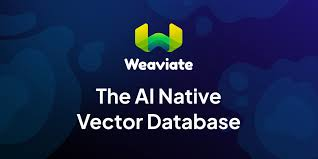

# 4 - Data ingestion and search with the Weaviate Vector Database.

In the previous jupyter notebook we were able to obtain document elements and extract and junk metadata.  In this jupyter notebook we are now ready to perform data ingestion and search using the Weaviate Vector Database.

Let's get started!

#### This notebook expects the following environment variables to bet set in the Openshift AI workbench.

|*Variable* | *Description*|
| -------- | ------- |
|`OPENAI_API_KEY`| The OpenAI API key used for embeddings and generative searches.|
|`DLAI_API_KEY`| Used by the UnstructuedIO API service key.|
|`DLAI_API_URL`| The UnstructuedIO API service endpoint.|

In [137]:
!pip install unstructured_client unstructured -q
# !pip install chromadb -q
# !pip install pysqlite3-binary -q


[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [138]:
# import pysqlite3
# import sys
# sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

In [139]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [140]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [ ]:
import json
from IPython.display import JSON

from unstructured_client import UnstructuredClient
from unstructured_client.models import shared
from unstructured_client.models.errors import SDKError

from unstructured.chunking.basic import chunk_elements
from unstructured.chunking.title import chunk_by_title
from unstructured.staging.base import dict_to_elements

In [142]:
import os

In [143]:
openai_api_key = os.getenv("OPENAI_API_KEY", None)
dlai_api_key = os.getenv("DLAI_API_KEY", None)
dlai_api_url = os.getenv("DLAI_API_URL", None)

if openai_api_key == None:
    logger.error("OPENAI_API_KEY is not set!")
if dlai_api_key == None:
    logger.error("DLAI_API_KEY is not set!")
if dlai_api_url == None:
    logger.error("DLAI_API_URL is not set!")

s = UnstructuredClient(
    api_key_auth=dlai_api_key,
    server_url=dlai_api_url,
)

## View the content of the patient chart pdf file
- <a href="example_files/CP_CHRT_C_G4M3BA_De-identified.pdf">Patient Chart (View PDF) -- Click Here</a>

## Use the Unstructured API

In [144]:
filename = "example_files/CP_CHRT_C_G4M3BA_De-identified.pdf"

with open(filename, "rb") as f:
    files=shared.Files(
        content=f.read(),
        file_name=filename,
    )

req = shared.PartitionParameters(files=files)

In [145]:
try:
    resp = s.general.partition(req)
except SDKError as e:
    print(e)

In [146]:
type(resp.elements[0])
resp.elements[2]

{'type': 'NarrativeText',
 'element_id': 'b1e6b19cf5095d5cabd2845a5f3f51d9',
 'text': "She has no past medical history of Angina pectoris (CMS/HCC), Arthritis, Asthma, Atrial fibrillation (CMS/HCC), Awareness under anesthesia, Basal cell carcinoma, Cancer (CMS/HCC), Chronic kidney disease, Chronic pain disorder, Chronic renal failure, COPD (chronic obstructive pulmonary disease) (CMS/HCC), Deep vein thrombosis (CMS/HCC), Delayed emergence from general anesthesia, Depression, Diabetes mellitus type I (CMS/HCC), Diabetic retinopathy (CMS/HCC), Dry eyes, Epilepsy (CMS/HCC), Eye trauma, GERD (gastroesophageal reflux disease), Glaucoma, Hard to intubate, Heart disease, Heart murmur, Hiatal hemia, HIV disease (CMS/HCC), Hypertension, Hypertensive retinopathy, Infectious viral hepatitis, Macular degeneration, Malignant hyperthermia, Melanoma (CMS/HCC), Mitral valve prolapse, Motion sickness, Myocardial infarction (CMS/HCC), Parkinson's disease (CMS/HCC), Peptic ulceration, PONV (postoperative

In [147]:
JSON(json.dumps(resp.elements[0:20], indent=2))

<IPython.core.display.JSON object>

## Find elements associated with patient chart sections

In [148]:
[x for x in resp.elements if x['type'] == 'Title' and 'SURGICAL HISTORY' in x['text'].lower()]

[]

In [149]:
sections = [
    "PAST MEDICAL HISTORY",
    "VACCINE HISTORY",
    "SURGICAL HISTORY",
    "SOCIAL HISTORY",
    "VITALS",
    "VIDEO EXAM VIA TELEMEDICINE",
    "ASSESSMENT & PLAN",
    "FOLLOW UP",
    "SIGNATURE",
]

In [150]:
section_ids = {}
for element in resp.elements:
    for section in sections:
        if element["text"] == section and element["type"] == "Title":
            section_ids[element["element_id"]] = section
            break

In [151]:
section_ids

{'da061e7b23ad36a4729f7ee39657b7a2': 'PAST MEDICAL HISTORY',
 '6c8dbb5374802cd239e1b79bb3a0bcf4': 'VACCINE HISTORY',
 '739ec169e9f67ffdd42e595921338a4e': 'SURGICAL HISTORY',
 '6c3cb75b3189082a62400014b632894b': 'SOCIAL HISTORY',
 'a3a664150ef280a7af534a7c1e1114db': 'VIDEO EXAM VIA TELEMEDICINE',
 'b217300f8cc2fa7150c186ea32efe177': 'ASSESSMENT & PLAN'}

In [152]:
section_to_id = {v: k for k, v in section_ids.items()}
[x for x in resp.elements if x["metadata"].get("parent_id") == section_to_id["SURGICAL HISTORY"]][0]

{'type': 'NarrativeText',
 'element_id': 'a1cc57d6952d90eba8bf16566cc4b75c',
 'text': '1. Pr explore parathyroid glands n/a. Procedure: neck exploration with parathyroidectomy',
 'metadata': {'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 1,
  'parent_id': '739ec169e9f67ffdd42e595921338a4e',
  'filename': 'CP_CHRT_C_G4M3BA_De-identified.pdf'}}

In [153]:
import json
with open('elements.json', 'w', encoding='utf-8') as f:
    json.dump(resp.elements, f, ensure_ascii=False, indent=4)

### Ingest Documents into Weaviate

Now that the pdf has been processed into json it can be ingested into the vector database.

#### 1) Install the Weaviate python SDK.

In [154]:
!pip install weaviate-client ijson -q


[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [155]:
import weaviate
import weaviate.classes as wvc
# from weaviate.auth import AuthApiKey
import os
import requests
import json
import ijson

In [156]:
def ingest_data(client, resp):
    """
    Create a Weaviate collection and configure it to use OpenAI to create
    vector embeddings and perform generative searches.

    Args:
        client (weaviate.connect): A client connection to Weaviate.
        resp (dict): The json dictionary to ingest.

    Returns:
        True if sucessful.
    """
    
    status = False
    symbols = client.collections.create(
        name="Charts",
        vectorizer_config=wvc.config.Configure.Vectorizer.text2vec_openai(
        ),
        generative_config=wvc.config.Configure.Generative.openai(
        )
    )

    # Settings for displaying the import progress
    counter = 0
    interval = 100  # Print progress every this many records; should be bigger than the batch_size

    logger.info("JSON streaming, to avoid running out of memory on large files...")
    with client.batch.fixed_size(batch_size=50) as batch:
            for element in resp.elements:
                parent_id = element["metadata"].get("parent_id")
                section = section_ids.get(parent_id, "")
                properties = {
                    # "type" : element["type"],
                    "text" : element["text"],
                    # "element_id" : element["element_id"],
                    # "metadata" : element["metadata"]
                }

                batch.add_object(
                    collection="Charts",
                    properties=properties,
                    # If you Bring Your Own Vectors, add the `vector` parameter here
                    # vector=obj.vector["default"]
                )

                # Calculate and display progress
                counter += 1
                if counter % interval == 0:
                    logger.info(f"Imported {counter} charts.")


    logger.info(f"Finished importing {counter} charts.")
    status = True
    return status

In [157]:
def semantic_search(charts, query='medical', limit=2) -> dict:
    """
    Perform a semantic (vector) search using natural language.

    Args:
        charts(weaviate.collection): A Weaviate collection.
        query(str): The query string
        limit(int): Determines how many results are returned.

    Returns:
        A dictionary containing the closest results in vector space.
    """
    logger.info(f'\nSemantic Search, query = {query}.')
    logger.info(f'limit = {limit}')
    response = charts.query.near_text(
        query=query,
        limit=limit
    )

    return_list = []
    for i in range(limit):
        return_list.append(response.objects[i].properties['text'])
        # return_list.append(response.objects[i].properties['element_id'])

    return return_list

In [158]:
def generative_search(charts, query=None, task=None, limit=2) -> str:
    """
    Perform a generative search (RAG) using natural language.

    Args:
        charts(weaviate.collection): A Weaviate collection.
        query(str): The query string
        task(str): The prompt to send to the LLM.
        limit(int): Determines how many results are returned.

    Returns:
        The string from the LLM.
    """
    logger.info(f'\nPerforming generative search, query = {query}, task = {task}, limit = {limit}.')
    logger.info(f'Prompt: {task}')
    logger.info(f'limit = {limit}')
    response = charts.generate.near_text(
        query=query,
        limit=limit,
        grouped_task=task
    )
    return response.generated

In [159]:
client = weaviate.connect_to_embedded(
    version="1.26.1",
    headers={
        "X-OpenAI-Api-Key": openai_api_key
    },
)

if client.is_ready():
    logger.info('')
    logger.info(f'Found {len(client.cluster.nodes())} Weaviate nodes.')
    logger.info('')
    for node in client.cluster.nodes():
        logger.info(node)
        logger.info('')

INFO: Started /opt/app-root/src/.cache/weaviate-embedded: process ID 2108
{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2024-09-30T18:19:46Z"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2024-09-30T18:19:46Z"}
{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2024-09-30T18:19:46Z"}
{"level":"info","msg":"module offload-s3 is enabled","time":"2024-09-30T18:19:46Z"}
{"level":"warning","msg":"Multiple vector spaces are present, GraphQL Explore and REST API list objects endpoint module include params has been disabled as a result.","time":"2024-09-30T18:19:46Z"}
{"level":"info","msg":"open cluster service","servers":{"Embedde

#### 2) Create the Weaviate Collection

In [160]:
client.collections.delete("Charts")

ingest_data(client, resp)

{"action":"load_all_shards","level":"error","msg":"failed to load all shards: context canceled","time":"2024-09-30T18:19:48Z"}
{"level":"warning","msg":"prop len tracker file /opt/app-root/src/.local/share/weaviate/charts/7onCtv5WzTGU/proplengths does not exist, creating new tracker","time":"2024-09-30T18:19:48Z"}
{"action":"hnsw_prefill_cache_async","level":"info","msg":"not waiting for vector cache prefill, running in background","time":"2024-09-30T18:19:48Z","wait_for_cache_prefill":false}
{"level":"info","msg":"Created shard charts_7onCtv5WzTGU in 630.004µs","time":"2024-09-30T18:19:48Z"}
{"action":"hnsw_vector_cache_prefill","count":1000,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2024-09-30T18:19:48Z","took":61434}
{"action":"telemetry_push","level":"info","msg":"telemetry started","payload":"\u0026{MachineID:4a42bd27-492c-4853-b759-9d4ea1fa6802 Type:INIT Version:1.26.1 NumObjects:0 OS:linux Arch:amd64 UsedModules:[generative-open

True

#### 3) Check the collection using a semantic search

The results returned by the next cell are directly from the vector database.

In [161]:
charts = client.collections.get("Charts")

query_texts=["Was the patient a smoker?"]
print()
print(semantic_search(charts, query_texts, 5))


['Reports that she has been smoking cigarettes. She has quit using smokeless tobacco. She reports current alconol use of about 3.0 standard drinks of alcohol per week. She reports that she does not use drugs.', 'Patient has a past medical history of Anxiety, Disease of thyroid gland, Migraine, Obstructive sleep apnea i Prediabetes.', 'Patient performed vitals:', 'PAST MEDICAL HISTORY', 'I saw this patient via an interactive audio and video telecommunications system.']


Notice the text formatting above lacks structure and readability. 
We can improve that by using a large language model that was training on the English language and recognizes entities that appear in
the vector database. Weaviate can perform this operation using retrieval augmented generation (RAG).

In [162]:
charts = client.collections.get("Charts")

query_text="Is this patient a smoker?"
prompt="Summarize the {text} in two paragraphs as you would to a physicians assistant."
print()
print(generative_search(charts, query_text, prompt, 50))


The patient reports a history of smoking cigarettes but has quit using smokeless tobacco. She consumes about 3.0 standard drinks of alcohol per week and denies drug use. Her past medical history includes anxiety, thyroid disease, migraine, obstructive sleep apnea, and prediabetes. During the telemedicine visit, her vitals were stable, and she appeared well without signs of acute distress.

The patient has no history of various medical conditions such as heart disease, diabetes, or chronic kidney disease. She underwent skin grafts for burns from a truck explosion. Medications, benefits, and side effects were reviewed, and follow-up appointments were recommended if symptoms persist. The patient was alert, oriented, and answered questions appropriately. She received a flu shot and tetanus vaccine, and her anxiety disorder was managed with lorazepam. Overall, the patient appeared well and was advised on further care and follow-up.


#### Close the Weaviate client connection.

In [163]:
client.close()

{"action":"restapi_management","docker_image_tag":"unknown","level":"info","msg":"Shutting down... ","time":"2024-09-30T18:19:52Z"}
{"action":"restapi_management","docker_image_tag":"unknown","level":"info","msg":"Stopped serving weaviate at http://127.0.0.1:8079","time":"2024-09-30T18:19:52Z"}
{"action":"telemetry_push","level":"info","msg":"telemetry terminated","payload":"\u0026{MachineID:4a42bd27-492c-4853-b759-9d4ea1fa6802 Type:TERMINATE Version:1.26.1 NumObjects:0 OS:linux Arch:amd64 UsedModules:[generative-openai text2vec-openai]}","time":"2024-09-30T18:19:52Z"}
{"level":"info","msg":"closing raft FSM store ...","time":"2024-09-30T18:19:52Z"}
{"level":"info","msg":"shutting down raft sub-system ...","time":"2024-09-30T18:19:52Z"}
{"level":"info","msg":"transferring leadership to another server","time":"2024-09-30T18:19:52Z"}
{"error":"cannot find peer","level":"error","msg":"transferring leadership","time":"2024-09-30T18:19:52Z"}
{"level":"info","msg":"closing raft-net ...","tim

##### Backup cells

In [164]:
def semantic_metadata_search(charts, query='medical', limit=2) -> dict:
    logger.info(f'\nSemantic Search, query = {query}.')
    logger.info(f'limit = {limit}')
    response = charts.query.near_text(
        query=query,
        limit=limit
    )

    return_list = []
    for i in range(limit):
        return_list.append(response.objects[i].properties['metadata'])
        # return_list.append(response.objects[i].properties['element_id'])

    return return_list

In [165]:
#
# Metadata query
#
# charts = client.collections.get("Charts")

# query_texts=["Did the patient have a skin graft?"]
# query_texts=["Was the patient a smoker?"]
# semantic_metadata_search(charts, query_texts)